# To Begin

This is a practical part of your ASR-TTS course. In total you will have 5 labs. Three of which will be focused on Automatic Speech Recognition and two on Text-to-Speech models. Each lab will last two hours and consist of two parts:
* Reading Part
* Coding Part 

In each part you might find question or tasks/activities to complete. The grading of the labs is explained below.

LAB 3/5

# What will you learn in LAB 2?

* What tensors are and how scalars, vectors, matrices, and higher-dimensional tensors are represented in practice.
* How tensor shapes encode meaning in ASR systems (e.g. batch size, time steps, feature dimensions).
* How to create, inspect, and manipulate tensors using common operations such as reshaping, transposing, and adding or removing dimensions.
* How typical ASR input and output tensors are structured, and why matching expected shapes is critical for models and losses.
* How common tensor shape mistakes arise in ASR pipelines (e.g. missing batch dimensions, swapped axes) and how to debug them.
* How underfitting and overfitting appear during ASR training, and how fine-tuning pre-trained models can help balance generalization and memorization.


# What Are Tensors?

A tensor is a container that holds numbers.
Nothing more. Nothing magical.
What makes tensors special is that they can have many dimensions and a shape that tells us how the numbers are organized.
In deep learning (and ASR), everything is a tensor: audio, features, model outputs, and labels.

In [1]:
import torch
import torch.nn as nn
import torchaudio
from speechbrain.inference.ASR import EncoderDecoderASR
from torch.utils.data import random_split


## Scalars — a tensor with no dimensions

A scalar is a single number.
It has no axes, only a value.

In [2]:
x = torch.tensor(3.14)
print(x)
print(x.shape)

# [] means: no dimensions.


tensor(3.1400)
torch.Size([])


## Vectors — one-dimensional tensors

A vector is a list of numbers.
It has one dimension.

In [3]:
v = torch.tensor([1.0, 2.0, 3.0])
print(v)
print(v.shape)


tensor([1., 2., 3.])
torch.Size([3])


## Question:

What is a dimension of a tensor? Explain in your own words.

In [4]:
# Answer 
# The dimension of a tensor is the size of the tensor in each dimension. For example,
# a 2D tensor has two dimensions, the first dimension is the number of rows and the second dimension is the number of columns.

Here is a full tensor example:

In [5]:
x = torch.tensor([
    [[1., 2., 3.],
     [4., 5., 6.],
     [4., 5., 6.],
     [7., 8., 9.]],

    [[10., 11., 12.],
     [13., 14., 15.],
     [4., 5., 6.],
     [16., 17., 18.]]
])

print(x)
print(x.shape)



tensor([[[ 1.,  2.,  3.],
         [ 4.,  5.,  6.],
         [ 4.,  5.,  6.],
         [ 7.,  8.,  9.]],

        [[10., 11., 12.],
         [13., 14., 15.],
         [ 4.,  5.,  6.],
         [16., 17., 18.]]])
torch.Size([2, 4, 3])


## Question: 

Explain what each number of torch.size output represente.

In [6]:
# For a tensor, torch.size the first number is the batch size, the second number is number of rows, the third number is number of columns.

## Matrices — two-dimensional tensors

A matrix is a table of numbers with rows and columns.

In [7]:
m = torch.tensor([
    [1.0, 2.0, 3.0],
    [4.0, 5.0, 6.0]
])
print(m)
print(m.shape)


tensor([[1., 2., 3.],
        [4., 5., 6.]])
torch.Size([2, 3])


## Tensors — more than two dimensions

When we go beyond tables, we usually say tensor.
In ASR, tensors often have three dimensions or more.

Typical ASR tensor:

(batch, time, features)

Example:

In [8]:
x = torch.randn(8, 300, 80)
print(x.shape)


torch.Size([8, 300, 80])


Meaning:

* 8 audio files (batch)
* 300 time frames
* 80 features per frame

## The batch dimension (very important)

Neural networks are built to process many examples at the same time, not one by one. Doing things in parallel is much faster on GPUs and modern CPUs.

Instead of giving the model:
* “here is one audio file”

we give it:
* “here are many audio files at once”

The batch dimension tells the model:
“How many examples am I processing at the same time?”



## Question 

Create a tensor with 12 audio files, 500 time frames and 90 features per frame

In [9]:
# Code here
example_tensor = torch.randn(12, 500, 90)
example_tensor.shape

torch.Size([12, 500, 90])

# Manipulating Tensors

## Reshaping — same numbers, different shape

Reshaping changes how numbers are grouped, not the numbers themselves.

In [10]:
x = torch.randn(8, 300, 80)
print(x.shape)
y = x.reshape(8, 24000)
print(y.shape)


torch.Size([8, 300, 80])
torch.Size([8, 24000])


## Transposing — swapping dimensions

Sometimes models expect dimensions in a different order.

In [11]:
x = torch.randn(8, 300, 80)
print(x.shape)
y = x.transpose(1, 2)
print(y.shape)


torch.Size([8, 300, 80])
torch.Size([8, 80, 300])


## Squeeze and Unsqueeze — adding or removing size-1 dimensions

Neural networks often expect tensors to have exact dimensions.

In [12]:
x = torch.randn(1, 300, 80)
print(x.shape)

y = x.squeeze(0)
print(y.shape)


torch.Size([1, 300, 80])
torch.Size([300, 80])


## Question:

squeeze removed a dimension, read the documentation and find a function to remove a dimension: https://docs.pytorch.org/docs/stable/torch.html

add a dimension to the tensor below:

In [13]:
# Your code here

x_add_dim = x.unsqueeze(-1)
print(x_add_dim.shape)


torch.Size([1, 300, 80, 1])


# Why tensor shapes cause most ASR bugs

In ASR, models expect very specific shapes.
If the shape is wrong, training crashes or gives nonsense results.

Common mistakes:

* Missing batch dimension
* Time and feature axes swapped
* Labels shape not matching predictions


Golden debugging rule:

print(tensor.shape)

👉 If you don’t know the shape, you don’t know what your code is doing.

## Question:

Below is a toy example of a model that has a bug. Debug it and fix the bug using one of the tensor manipulation techniques from this lesson.

Reread the lesson again if you neeed help fixing it.

HINT:

In ASR, most bugs happen at these boundaries:

* After feature extraction
* Before model forward
* Before loss / decoding

print the shapes!

* A lot of ASR bugs are literally “2D vs 3D”.

print("dims:", features.dim(), "shape:", features.shape)



In [14]:
class SimpleASR(nn.Module):
    def __init__(self, n_features=80, hidden=64, n_classes=30):
        super().__init__()
        self.rnn = nn.LSTM(n_features, hidden, batch_first=True)
        self.linear = nn.Linear(hidden, n_classes)

    def forward(self, x):
        if x.dim() != 3:
            raise ValueError(
                f"Expected input shape (B, T, F), got {x.shape}"
            )
        y, _ = self.rnn(x)
        return self.linear(y)

model = SimpleASR()

features = torch.randn(300, 80) 
features = features.unsqueeze(0)

out = model(features)             
print("Output shape:", out.shape)

Output shape: torch.Size([1, 300, 30])


## Question

Explain what was the big in your own words, and what steps you took to debug it.

In [15]:
# Your answer
# The number of baches was not in the features shape. As we need to have B, T, F so I added one for batch dimension with unsqueeze method.

## Linear Layer

Think of a Linear layer as a very simple machine with two rules.

* The first rule is: how many numbers go in.
* The second rule is: how many numbers come out.

When you write nn.Linear(24000, 10), you are telling the machine: “I will give you 24000 numbers at a time, and you must give me back 10 numbers.” The machine does not care how many examples you give it at once — that part is handled automatically. It only checks the last group of numbers. So if you give it one example, it expects (24000) numbers; if you give it many examples, it expects (batch, 24000) numbers. After the Linear layer, each example now has 10 numbers instead of 24000, so the output shape becomes (batch, 10). 



In [16]:
class UtteranceClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(300 * 80, 10)

    def forward(self, x):
        x = x.view(x.shape[0], -1)

        return self.linear(x)

model = UtteranceClassifier()


features = torch.randn(4, 300, 80)
print("Input shape:", features.shape)

out = model(features)
print("Output shape:", out.shape)


Input shape: torch.Size([4, 300, 80])
Output shape: torch.Size([4, 10])


## Question:

Above is another toy code with a big, identify and fix it using tensor manipulation techniques from this lesson. Below, describe how you debugged it and solved it. 
Describe everything: what linear layer expected, what you gave it, what caused an error and so on.

HINT:
A Linear layer never understands tables — it only understands rows.

In [17]:
# Your answer
# Because Linear layers don’t understand tables/matrices — they only understand rows of features.
# x.view reshapes each matrix into a row vector for the Linear layer to process.


## Question:

Below is another code with an error, for this code **use the audio file abailable in lab_3 folder**. Find the error and describe your debugging process. Keep in mind that these errors are induced bu me but they **often** occur when working with 3D data and asr.

In [18]:
asr = EncoderDecoderASR.from_hparams(
    source="speechbrain/asr-crdnn-rnnlm-librispeech",
    savedir="pretrained_models/asr-crdnn-rnnlm-librispeech",
)

audio_path = "audio.wav"  
wav, sr = torchaudio.load(audio_path)

wav = wav.mean(dim=0, keepdim=True)

print("Loaded sample rate:", sr)
print("Loaded waveform shape (channels, time):", wav.shape)

if wav.shape[0] != 1:
    raise ValueError(
        f"Got {wav.shape} (channels={wav.shape[0]}). "
    )


wav_batch = wav
wav_lens = torch.ones(wav.shape[0])

with torch.no_grad():
    text = asr.transcribe_batch(wav_batch, wav_lens)

print("\nTranscript:")
print(text)


Loaded sample rate: 16000
Loaded waveform shape (channels, time): torch.Size([1, 78480])

Transcript:
(['HE BEGAN A CONFUSED COMPLAINT AGAINST THE WIZARD WHO HAD VANISHED BEHIND THE CURTAIN ON THE LEFT'], [[16, 494, 5, 106, 42, 82, 4, 401, 172, 40, 7, 204, 65, 2, 226, 202, 200, 110, 35, 3, 325, 15, 186, 4, 666, 2, 619, 469, 39, 2, 402]])


# Fine-tunning

Fine-tuning means starting from a model that already knows general speech patterns (for example, wav2vec trained on thousands of hours of audio) and then slightly adjusting it on your own smaller dataset so it adapts to your task, instead of learning everything from scratch. In practice, this is done by freezing most of the pre-trained model and training only a small part (like the output layer), or by unfreezing layers gradually with a small learning rate so the model does not forget what it already knows; if you train too much or unfreeze too many layers with little data, the model will overfit and simply memorize the training examples.

# Fine-tuning a Wav2vec Model for Automatic Speech Recognition

The ASR system used in the first two labs relied on an acoustic model made up of two main components: a *feature* extractor (based on the [wav2vec](https://arxiv.org/pdf/2006.11477) architecture) and a *classifier* (a linear layer). The model then operates in two stages:

1. The speech waveform is passed to the feature extractor to transform it into a latent representation (= the *feature maps*).
2. The latent representation is passed to a classification layer to compute the probability of each character (= the *emission matrix*).

<center><img src="https://github.com/magronp/magronp.github.io/blob/master/images/wav2vec2asr.png?raw=true" width="800"></center>

To train such a model in practice, a two-stage proces is used. First, the wav2vec model alone is pre-trained in a self-supervised manner (using speech data only). Then, the classification layer is added and the whole model \{wav2vec+classifier\} is fine-tuned in a supervised manner (from speech+transcript data).

In the previous labs, we have used a whole model that was already pre-trained and fine-tuned for ASR. In this lab, we start from the pre-trained wav2vec model, and we reproduce the process of fine-tuning it for ASR. 

In [19]:
import torch
from torch import nn
from torch.utils.data import Dataset
import torchaudio
import IPython
import os
import fnmatch
import copy
import matplotlib.pyplot as plt

In [20]:
torch.random.manual_seed(0);

MAX_FILES = 100 # lower this number for processing a subset of the dataset

In [21]:
# Main dataset path - If needed, you can change it HERE but NOWHERE ELSE in the notebook!
data_dir = "../../asr-dataset/"

In [22]:
# Speech and transcripts sub-directories paths
data_speech_dir = os.path.join(data_dir, 'speech')
data_transc_dir = os.path.join(data_dir, 'transcription')

## Preparation

## Question

In [23]:
## Load an example audio file and plot a waveform the way we did in class 1
# Example file
audio_file = "61-70968-0000.wav"
audio_file_path = os.path.join(data_speech_dir, audio_file)
print(f"Audio file path: {audio_file_path}")

waveform, sr = torchaudio.load(audio_file_path, channels_first=True)
IPython.display.Audio(data=waveform, rate=sr)

Audio file path: ../../asr-dataset/speech/61-70968-0000.wav


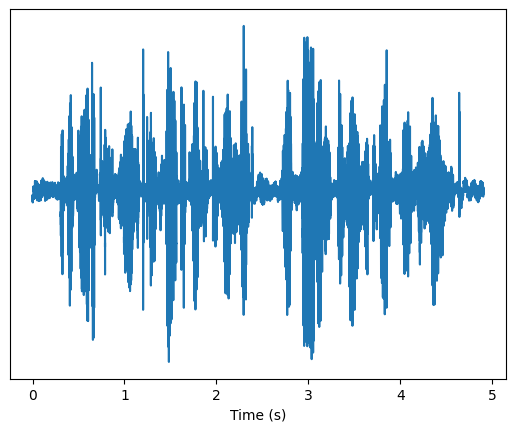

In [24]:
# Plot the speech signal waveform
plt.figure()
xt = torch.arange(waveform.size(1)) / sr
plt.plot(xt, waveform.T)
plt.yticks([])
plt.xlabel("Time (s)")
plt.show()

In [25]:
# Write a function to get true transcript. Use the previous labs to help you

def get_true_transcript(transc_file_path):
    with open(transc_file_path, "r") as f:
        true_transcript = f.read().strip().lower()

    # Replace spaces with | (CTC convention)
    true_transcript = true_transcript.replace(" ", "|")

    # Convert to list of characters
    true_transcript = list(true_transcript)

    return true_transcript

# Load and display the true transcription
transc_file_path = os.path.join(data_transc_dir, audio_file.replace('wav', 'txt'))
true_transcript = get_true_transcript(transc_file_path)
print(true_transcript)

['h', 'e', '|', 'b', 'e', 'g', 'a', 'n', '|', 'a', '|', 'c', 'o', 'n', 'f', 'u', 's', 'e', 'd', '|', 'c', 'o', 'm', 'p', 'l', 'a', 'i', 'n', 't', '|', 'a', 'g', 'a', 'i', 'n', 's', 't', '|', 't', 'h', 'e', '|', 'w', 'i', 'z', 'a', 'r', 'd', '|', 'w', 'h', 'o', '|', 'h', 'a', 'd', '|', 'v', 'a', 'n', 'i', 's', 'h', 'e', 'd', '|', 'b', 'e', 'h', 'i', 'n', 'd', '|', 't', 'h', 'e', '|', 'c', 'u', 'r', 't', 'a', 'i', 'n', '|', 'o', 'n', '|', 't', 'h', 'e', '|', 'l', 'e', 'f', 't']


In [26]:
# We provide the list of labels (=characters) that can be found in the dataset
labels = ['-', '|', 'e', 't', 'a', 'o', 'n', 'i', 'h', 's', 'r', 'd', 'l', 'u', 'm',
          'w', 'c', 'f', 'g', 'y', 'p', 'b', 'v', 'k', "'", 'x', 'j', 'q', 'z']
n_labels = len(labels)

We need to transform the true transcript into a list of integers in order to feed it to a training loss function. To that end, we define a dictionary `dico_labels` that maps each character in the list of possible labels to an integer (for instance, `dico_labels['e']=2` or `dico_labels['a']=4`).

In [27]:
# using the 'labels' list above, define this dictionary
dico_labels = {}
for index, element in enumerate(labels):
    dico_labels[element] = index

In [28]:
# Apply dico_labels to the true transcript, and build a tensor from it
target_indices = [dico_labels[c] for c in true_transcript]
target_indices = torch.tensor(target_indices, dtype=torch.long)
print(target_indices)

tensor([ 8,  2,  1, 21,  2, 18,  4,  6,  1,  4,  1, 16,  5,  6, 17, 13,  9,  2,
        11,  1, 16,  5, 14, 20, 12,  4,  7,  6,  3,  1,  4, 18,  4,  7,  6,  9,
         3,  1,  3,  8,  2,  1, 15,  7, 28,  4, 10, 11,  1, 15,  8,  5,  1,  8,
         4, 11,  1, 22,  4,  6,  7,  9,  8,  2, 11,  1, 21,  2,  8,  7,  6, 11,
         1,  3,  8,  2,  1, 16, 13, 10,  3,  4,  7,  6,  1,  5,  6,  1,  3,  8,
         2,  1, 12,  2, 17,  3])


## Acoustic model

Torchaudio comprises many models whose pretrained weights can be loaded directly (the list can be found [here](https://pytorch.org/audio/stable/pipelines.html#id3)). Here we use `WAV2VEC2_BASE`, which is pre-trained on speech data, but not fine-tuned for ASR.

We can apply it to the waveform to compute the feature maps, which is a tensor of size `[1, time steps, feature dim]` (recall that `1` corresponds to the batch size).

In [29]:
# Load the acoustic model: here it's a Wav2vec base that is not fine-tuned. Use previous labs to help you
model_name = 'WAV2VEC2_BASE'
bundle = getattr(torchaudio.pipelines, model_name)
acoustic_model = bundle.get_model()

# Display model architecture
print(acoustic_model)


Wav2Vec2Model(
  (feature_extractor): FeatureExtractor(
    (conv_layers): ModuleList(
      (0): ConvLayerBlock(
        (layer_norm): GroupNorm(512, 512, eps=1e-05, affine=True)
        (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
      )
      (1-4): 4 x ConvLayerBlock(
        (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
      )
      (5-6): 2 x ConvLayerBlock(
        (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,), bias=False)
      )
    )
  )
  (encoder): Encoder(
    (feature_projection): FeatureProjection(
      (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (projection): Linear(in_features=512, out_features=768, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (pos_conv_embed): ConvolutionalPositionalEmbedding(
        (conv): ParametrizedConv1d(
          768, 768, kernel_size=(128,), stride=(1,), padding=(64,), groups=16
          (parametriza

In [30]:
# Compute the feature maps
with torch.inference_mode():
    features, _ = acoustic_model(waveform)

print(features.shape)

torch.Size([1, 245, 768])


This model includes a wav2vec feature extractor (so it should be re-instaciated in the `__init__` method) and a linear classification layer that takes the feature maps and outputs log-probabilities per class (thus it has to use a [log softmax](https://pytorch.org/docs/stable/generated/torch.nn.LogSoftmax.html) activation after classification).

In [31]:
class Wav2vecASR(nn.Module):
    def __init__(self, output_size):
        super().__init__()

        self.wav2vec = getattr(torchaudio.pipelines, 'WAV2VEC2_BASE').get_model()
        self.feature_dim = self.wav2vec.encoder.feature_projection.projection.out_features
        self.output_layer = nn.Linear(self.feature_dim, output_size)
    
    def forward(self, x):
        features, _ = self.wav2vec(x)
        emission = self.output_layer(features)
        emission = emission.log_softmax(dim=-1)
        return emission


In [32]:
# Instanciate the model
output_size = n_labels
model = Wav2vecASR(output_size)

In [33]:
# A function to count the number of trainable parameters
def count_tlearnable_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print('Number of trainable parameters:', count_tlearnable_params(model))

Number of trainable parameters: 94393245


The model is very large (90M+ parameters) mostly because of the wav2vec part. To speed training in this lab, we freeze the wav2vec part and we only train the classification layer. To that end, we need to set `requires_grad = False` for the wav2vec's parameters.

In [34]:
# Define a function to freeze parameters, apply it to "wav2vec" part of the model,
# and print the new number of trainable parameters
def freeze_params(m):
    for param in m.parameters():
        param.requires_grad = False
    return
    
model.wav2vec.apply(freeze_params)

print('Number of trainable parameters:', count_tlearnable_params(model))

Number of trainable parameters: 22301


In [35]:
# Initialization function for the network's parameters
def init_params(m, seed=0):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight.data, generator=torch.manual_seed(seed))
        if m.bias is not None:
            m.bias.data.fill_(0.01)
    return model 

In [36]:
model.output_layer.apply(init_params)

Linear(in_features=768, out_features=29, bias=True)

torch.Size([1, 245, 29])


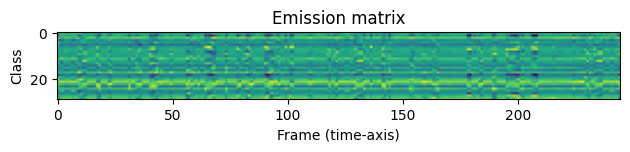

In [37]:
with torch.inference_mode():
    emission = model(waveform)
print(emission.shape)

# Vizualize the emission matrix
plt.figure()
plt.imshow(emission[0].cpu().T)
plt.title("Emission matrix")
plt.xlabel("Frame (time-axis)")
plt.ylabel("Class")
plt.tight_layout()
plt.show()

In [38]:
# We provide a function to get a transcript from the emission matrix (similar to the greedy decoder from lab 1)
def transcript_from_emission(emission, labels):
    indices = torch.argmax(emission, dim=-1)  # take the most likely index at each time step
    indices = torch.unique_consecutive(indices, dim=-1) # remove duplicates
    indices = [i for i in indices if i != 0] # remove the blank token
    transcript = "".join([labels[i] for i in indices]) # convert integers back into characters
    transcript = transcript.lower()
    return transcript

# The transcript using a non-trained model should look bad
print(transcript_from_emission(emission[0], labels))

vbfplbvkbvb'bevbfkfbfbvbvfbvb'nvb'bivbsqvebnzbvbnbnbvbvbvlbnbvkbvb'ebv'bibvb'sbizbqnibzbyvebvlvbv


## Dataset

We now need to define the `Dataset` class, to efficiently load the speech data and true transcript (in the form of indices / integers).

The `__getitem__` method returns three outputs:

- `waveform`: a tensor containing the speech waveform
- `true_transcript`: the true transcript as per using the provided loading function
- `target_indices`: a tensor containing the integers corresponding to the transcript

The `__init__` method should make use of the `MAX_FILES` variable to limit the size of the dataset (for speed).

In [39]:
# ASR Dataset class
class ASRdataset(Dataset):
    def __init__(self, data_speech_dir, data_transc_dir, dico_labels, MAX_FILES=None):
        self.data_speech_dir = data_speech_dir
        self.data_transc_dir = data_transc_dir
        self.audio_files = self._find_files(data_speech_dir)[:MAX_FILES]
        self.dico_labels = dico_labels

    def __len__(self):
        return len(self.audio_files)

    def __getitem__(self, index):
        # load the waveform
        audio_file = self.audio_files[index]
        audio_file_path = os.path.join(self.data_speech_dir, audio_file)
        waveform, _ = torchaudio.load(audio_file_path, channels_first=True)
        # load the true transcript
        transc_file_path = os.path.join(self.data_transc_dir, audio_file.replace('wav', 'txt'))
        true_transcript = get_true_transcript(transc_file_path)
        # transform transcript into list of integers
        target_indices = [self.dico_labels[c] for c in true_transcript]
        target_indices = torch.tensor(target_indices, dtype=torch.long)
        return waveform, true_transcript, target_indices

    def _find_files(self, directory, pattern='*.wav'):
        """Recursively finds all files matching the pattern."""
        files = []
        for root, _, filenames in os.walk(directory):
            for filename in fnmatch.filter(filenames, pattern):
                files.append(filename)
        files = sorted(files)
        return files


In [40]:
# Instanciate the ASR dataset and print its length
asrdataset = ASRdataset(data_speech_dir, data_transc_dir, dico_labels, MAX_FILES=MAX_FILES)
print('Dataset length:', len(asrdataset))

# Get the first data sample, and print some information
waveform, true_transcript, target_indices = asrdataset[0]
print(waveform.shape)
print(true_transcript)
print(target_indices)

Dataset length: 100
torch.Size([1, 70560])
['a', 'n', 'g', 'o', 'r', '|', 'p', 'a', 'i', 'n', '|', 'p', 'a', 'i', 'n', 'f', 'u', 'l', '|', 't', 'o', '|', 'h', 'e', 'a', 'r']
tensor([ 4,  6, 18,  5, 10,  1, 20,  4,  7,  6,  1, 20,  4,  7,  6, 17, 13, 12,
         1,  3,  5,  1,  8,  2,  4, 10])


In real-life applications (and as we usually do in the "Neural Networks" labs), we assemble the data samples into *batches* for efficiency. However, our data points here have different lenghts in general: two speech waveforms / two transcripts are not guaranteed to have the same duration / number of characters. Therefore, in such a case we need to customize the dataloader such that it performs some [padding operation](https://www.codefull.org/2018/11/use-pytorchs-dataloader-with-variable-length-sequences-for-lstm-gru/) in order to yield data samples of same length. However, to keep things simple in this lab, we skip this padding operation, and we do not work with batches but rather iterate over the dataset directly.

## Training with the CTC loss

For a given data sample in the dataset, we have:
- the emission matrix (log-probability of each character over time frames)
- the true transcript (represented as a list of integers corresponding to each character)

However, to train our network, we need to obtain an estimated transcript so that we can compute a loss between the true and estimated transcripts. This requires some post-processing of the emission matrix, but the good news is that we don't have to do it, the [CTC loss](https://pytorch.org/docs/stable/generated/torch.nn.CTCLoss.html) handles that for us!

In lab 2 we have use the CTC algorithm to perform inference, but it can also be used as a loss function to train an ASR network. Not only the CTC loss handles the post-processing from the emission matrix, but its great advantage is that it performs alignment from input/output pairs of different lengths, so we don't have to explicitly align each character in the transcript with a time frame in the emission matrix.

In Pytorch, [CTC loss](https://pytorch.org/docs/stable/generated/torch.nn.CTCLoss.html) is fed with the the emission matrix and the tensor containing target indices (corresponding to the true transcript). We also need to give it the input and target lengths explicitly: indeed, even though here we don't manipulate batches / we don't do padding, in general this would be the case so we need to let the function know what is the actual input/target length (before padding).

In [41]:
# Compute the emission matrix (not in inference mode such that we keep track of the gradients)
emission = model(waveform)
emission = emission[0] #remove the "batch" dimension (since here batch_size=1)

# Define the input and target lengths as tensors
T = emission.shape[0]
L = len(target_indices)
input_length = torch.tensor(T, dtype=torch.long)
target_length = torch.tensor(L, dtype=torch.long)

# Instanciate a loss object
ctc_loss = nn.CTCLoss()

# Compute the loss
loss = ctc_loss(emission, target_indices, input_length, target_length)
print(loss.item())

# Compute the gradients
loss.backward()

22.328563690185547


Function `training_wav2vecASR` is used to train the model. It is similar to what you usually do in the Neural Networks labs, although here you do not build batches of data (thus we don't need a `Dataloader` object). Instead, you directly iterate over the `Dataset`. The training function uses an Adam optimizer, and no validation.

In [42]:
#Training function
def training_wav2vecASR(model, train_dataloader, num_epochs, loss_fn, learning_rate):

    model_tr = copy.deepcopy(model)
    model_tr.train()
    optimizer = torch.optim.Adam(model_tr.parameters(), lr=learning_rate)
    train_losses = []

    for epoch in range(num_epochs):
        tr_loss = 0
        for data_sample in asrdataset:
            
            # Get the data
            waveform, true_trans, target_indices = data_sample
            
            # Apply the model
            emission = model_tr(waveform)
            emission = emission.squeeze()
            
            #print(true_trans)
            #print(transcript_from_emission(emission, labels))

            # Get the input and target lengths
            input_length = torch.tensor(emission.shape[0], dtype=torch.long)
            target_length = torch.tensor(len(target_indices), dtype=torch.long)
    
            # Compute the CTC loss
            loss = loss_fn(emission, target_indices, input_length, target_length)

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    
            tr_loss += loss.item()
    
        # Normalize and store loss
        tr_loss = tr_loss / len(asrdataset)
        train_losses.append(tr_loss)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {tr_loss:.4f}")

    return model_tr, train_losses

In [43]:
# Training parameters (only one epoch for speed)
num_epochs = 1
learning_rate = 0.1
loss_fn = nn.CTCLoss()

model_tr, train_losses = training_wav2vecASR(model, asrdataset, num_epochs, loss_fn, learning_rate)

Epoch [1/1], Loss: 13.8632


## Question: 

What do you observe about the training process? Is it fast or slow? Why?

## Overfitting on one sample

Even when the training is slow, we can assess that our training pipeline works properly by conducting training on a unique sample, and checking the transcript on the same sample. This technique (= overfitting on one sample) is useful to "crash test" if everything runs and if our model / training pipeline has any chance to work on a larger dataset.

We will instanciate a model from scratch, freeze the wav2part, and initialize the classification layer. Build a dataset made up of 1 sample (use the `MAX_FILES` parameter), and conduct training for 50 epoch using this dataset. Once the model is trained, you will compute the emission matrix from this sample's waveform and the estimated transcript. Display the true and estimated transcripts. Also do the same on another sentence so that you can assess that the model is not able to generalize properly.

In [44]:
# Instanciate a model, freeze the wav2vec part, and initialize the classifier
model = Wav2vecASR(n_labels)
model.wav2vec.apply(freeze_params)
model.output_layer.apply(init_params)

# Build a very small dataset
asrdataset = ASRdataset(data_speech_dir, data_transc_dir, dico_labels, MAX_FILES=1)

# Training
num_epochs = 50
model_tr, train_losses = training_wav2vecASR(model, asrdataset, num_epochs, loss_fn, learning_rate)

# Save the model's parameters
torch.save(model_tr.state_dict(), 'model_wav2vecASR.pt')

Epoch [1/50], Loss: 22.5976
Epoch [2/50], Loss: 15.7619
Epoch [3/50], Loss: 16.1619
Epoch [4/50], Loss: 14.7077
Epoch [5/50], Loss: 12.3575
Epoch [6/50], Loss: 9.9600
Epoch [7/50], Loss: 6.5252
Epoch [8/50], Loss: 6.1703
Epoch [9/50], Loss: 10.2163
Epoch [10/50], Loss: 6.7613
Epoch [11/50], Loss: 3.4181
Epoch [12/50], Loss: 4.7721
Epoch [13/50], Loss: 3.3417
Epoch [14/50], Loss: 3.9217
Epoch [15/50], Loss: 5.0918
Epoch [16/50], Loss: 6.2030
Epoch [17/50], Loss: 3.2579
Epoch [18/50], Loss: 2.9763
Epoch [19/50], Loss: 5.2761
Epoch [20/50], Loss: 2.0475
Epoch [21/50], Loss: 1.8155
Epoch [22/50], Loss: 0.8868
Epoch [23/50], Loss: 2.6840
Epoch [24/50], Loss: 2.3123
Epoch [25/50], Loss: 1.6213
Epoch [26/50], Loss: 0.9358
Epoch [27/50], Loss: 3.4909
Epoch [28/50], Loss: 2.1993
Epoch [29/50], Loss: 2.3292
Epoch [30/50], Loss: 1.9998
Epoch [31/50], Loss: 1.9869
Epoch [32/50], Loss: 2.1326
Epoch [33/50], Loss: 3.3551
Epoch [34/50], Loss: 2.5006
Epoch [35/50], Loss: 1.1372
Epoch [36/50], Loss: 13

In [45]:
# Load the data sample
waveform, true_transcript, _ = asrdataset[0]

# Instanciate the model and load the trained parameters
model = Wav2vecASR(n_labels)
model.load_state_dict(torch.load('model_wav2vecASR.pt', weights_only=True))

# Apply the model and get the estimated transcript
with torch.inference_mode():
    emission = model(waveform)
    est_transcript = transcript_from_emission(emission[0], labels)



In [46]:
## Display true and estimated transcripts here
print(true_transcript)
print(est_transcript)

['a', 'n', 'g', 'o', 'r', '|', 'p', 'a', 'i', 'n', '|', 'p', 'a', 'i', 'n', 'f', 'u', 'l', '|', 't', 'o', '|', 'h', 'e', 'a', 'r']
angor|pain|aianful|to|heaa


In [47]:
# Try it on a different sentence
asrdataset_test = ASRdataset(data_speech_dir, data_transc_dir, dico_labels, MAX_FILES=2)
waveform, true_transcript, _ = asrdataset_test[1]

# Apply the model and get the estimated transcript
with torch.inference_mode():
    emission = model(waveform)
    est_transcript = transcript_from_emission(emission[0], labels)

In [48]:
## Display true and estimated transcripts here 
print(true_transcript)
print(est_transcript)

['h', 'e', 'a', 'v', 'e', 'n', '|', 'a', '|', 'g', 'o', 'o', 'd', '|', 'p', 'l', 'a', 'c', 'e', '|', 't', 'o', '|', 'b', 'e', '|', 'r', 'a', 'i', 's', 'e', 'd', '|', 't', 'o']
goo


## Question

When training the model how do you know if the model is learning properly, what do you code and inspect? Explain in depth.
Documentation to read: https://medium.com/data-science/learning-curve-to-identify-overfitting-underfitting-problems-133177f38df5

In [49]:
## Your answer
# To know whether a model is learning properly, we monitor training and validation losses,
#  task-specific metrics, and learning curves over epochs, inspect the gap between training
#  and validation performance to detect underfitting or overfitting, and qualitatively analyze
#  model outputs to ensure meaningful generalization rather than memorization.

# Evaluating Models

We need a new function to be able to split the dataset into train and val. To choose a good validation split, the validation data must be completely unseen during training and representative of the same task and conditions as the training data; a common rule of thumb is to keep about 10–30% of the data for validation, making sure it contains different speakers or utterances when possible, and to use it to monitor when validation performance stops improving, which tells you when to stop fine-tuning or adjust your hyperparameters.

In [50]:
def training_wav2vecASR2(model, train_dataset, val_dataset, num_epochs, loss_fn, learning_rate):
    model_tr = copy.deepcopy(model)
    model_tr.train()

    optimizer = torch.optim.Adam(model_tr.parameters(), lr=learning_rate)
    train_losses, val_losses = [], []

    for epoch in range(num_epochs):
        tr_loss = 0.0

        for waveform, true_trans, target_indices in train_dataset:
            emission = model_tr(waveform)
            emission = emission.squeeze()

            input_length = torch.tensor(emission.shape[0], dtype=torch.long)
            target_length = torch.tensor(len(target_indices), dtype=torch.long)

            loss = loss_fn(emission, target_indices, input_length, target_length)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            tr_loss += loss.item()

        tr_loss = tr_loss / max(1, len(train_dataset))
        train_losses.append(tr_loss)

        # validation curve
        vl_loss = eval_ctc_loss(model_tr, val_dataset, loss_fn)
        val_losses.append(vl_loss)

        print(f"Epoch [{epoch+1}/{num_epochs}]  Train: {tr_loss:.4f}  Val: {vl_loss:.4f}")

    return model_tr, train_losses, val_losses


In [51]:
def eval_ctc_loss(model, dataset, loss_fn):
    model.eval()
    total = 0.0

    with torch.no_grad():
        for waveform, true_trans, target_indices in dataset:
            emission = model(waveform)  

            emission = emission.squeeze()

            input_length = torch.tensor(emission.shape[0], dtype=torch.long)
            target_length = torch.tensor(len(target_indices), dtype=torch.long)

            loss = loss_fn(emission, target_indices, input_length, target_length)
            total += loss.item()

    model.train()
    return total / max(1, len(dataset))


In [52]:
MAX_FILES = 50  
asrdataset = ASRdataset(data_speech_dir, data_transc_dir, dico_labels, MAX_FILES=MAX_FILES)

val_ratio = 0.2
n_total = len(asrdataset)
n_val = max(1, int(n_total * val_ratio))
n_train = n_total - n_val

train_ds, val_ds = random_split(asrdataset, [n_train, n_val])

print("Train:", len(train_ds), "Val:", len(val_ds))


Train: 40 Val: 10


In [53]:
model = Wav2vecASR(n_labels)
model.wav2vec.apply(freeze_params)
model.output_layer.apply(init_params)

Linear(in_features=768, out_features=29, bias=True)

Epoch [1/50]  Train: 15.0543  Val: 15.4806
Epoch [2/50]  Train: 13.4027  Val: 14.6608
Epoch [3/50]  Train: 11.1393  Val: 12.1972
Epoch [4/50]  Train: 9.4267  Val: 11.1108
Epoch [5/50]  Train: 9.5980  Val: 12.0170
Epoch [6/50]  Train: 8.4896  Val: 11.0842
Epoch [7/50]  Train: 10.1847  Val: 14.8967
Epoch [8/50]  Train: 10.6353  Val: 13.9434
Epoch [9/50]  Train: 12.8760  Val: 16.4744
Epoch [10/50]  Train: 10.7521  Val: 15.3449
Epoch [11/50]  Train: 12.4824  Val: 23.1979
Epoch [12/50]  Train: 12.1837  Val: 12.5596
Epoch [13/50]  Train: 10.2862  Val: 13.8345
Epoch [14/50]  Train: 10.6035  Val: 11.8191
Epoch [15/50]  Train: 9.4262  Val: 11.4765
Epoch [16/50]  Train: 9.4555  Val: 10.8691
Epoch [17/50]  Train: 9.5522  Val: 12.1295
Epoch [18/50]  Train: 10.3523  Val: 15.5750
Epoch [19/50]  Train: 9.8982  Val: 13.4515
Epoch [20/50]  Train: 10.2835  Val: 11.9459
Epoch [21/50]  Train: 8.8207  Val: 13.5079
Epoch [22/50]  Train: 8.6299  Val: 11.5122
Epoch [23/50]  Train: 8.7382  Val: 12.4023
Epoch [

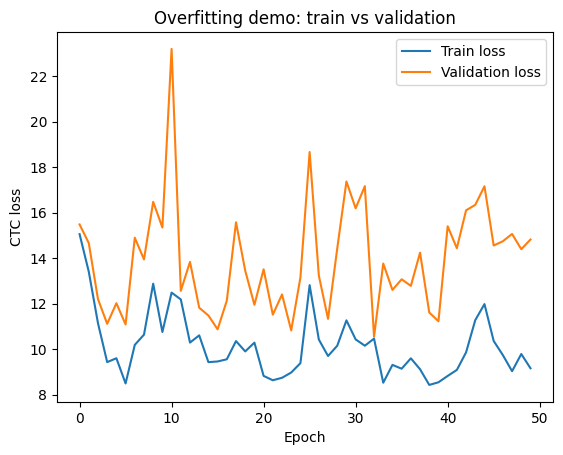

In [55]:
model_tr, train_losses, val_losses = training_wav2vecASR2(
    model, train_ds, val_ds, num_epochs=50, loss_fn=loss_fn, learning_rate=learning_rate
)

plt.figure()
plt.plot(train_losses, label="Train loss")
plt.plot(val_losses, label="Validation loss")
plt.xlabel("Epoch")
plt.ylabel("CTC loss")
plt.title("Overfitting demo: train vs validation")
plt.legend()
plt.show()


## Question

Experiment with MAX_FILES and tell me any changes you observe in the graph. Why do they occur?

In [57]:
model = Wav2vecASR(n_labels)
model.wav2vec.apply(freeze_params)
model.output_layer.apply(init_params)

Linear(in_features=768, out_features=29, bias=True)

In [58]:
# Your code
MAX_FILES = 20  
asrdataset = ASRdataset(data_speech_dir, data_transc_dir, dico_labels, MAX_FILES=MAX_FILES)

val_ratio = 0.2
n_total = len(asrdataset)
n_val = max(1, int(n_total * val_ratio))
n_train = n_total - n_val

train_ds, val_ds = random_split(asrdataset, [n_train, n_val])

print("Train:", len(train_ds), "Val:", len(val_ds))

Train: 16 Val: 4


Epoch [1/50]  Train: 17.7673  Val: 17.5247
Epoch [2/50]  Train: 12.0263  Val: 17.1624
Epoch [3/50]  Train: 15.4689  Val: 14.5270
Epoch [4/50]  Train: 11.7631  Val: 18.3261
Epoch [5/50]  Train: 12.2357  Val: 16.9211
Epoch [6/50]  Train: 11.4313  Val: 14.2988
Epoch [7/50]  Train: 9.0503  Val: 13.9870
Epoch [8/50]  Train: 8.6602  Val: 14.4639
Epoch [9/50]  Train: 7.5142  Val: 11.8503
Epoch [10/50]  Train: 7.2572  Val: 12.5232
Epoch [11/50]  Train: 7.8495  Val: 13.7306
Epoch [12/50]  Train: 7.1154  Val: 14.9052
Epoch [13/50]  Train: 8.7008  Val: 16.7953
Epoch [14/50]  Train: 9.4613  Val: 16.7149
Epoch [15/50]  Train: 8.9854  Val: 15.1341
Epoch [16/50]  Train: 7.4110  Val: 15.2397
Epoch [17/50]  Train: 8.4191  Val: 13.3557
Epoch [18/50]  Train: 9.1671  Val: 15.4647
Epoch [19/50]  Train: 9.4251  Val: 19.8327
Epoch [20/50]  Train: 14.7216  Val: 14.3108
Epoch [21/50]  Train: 9.1018  Val: 15.0611
Epoch [22/50]  Train: 8.6722  Val: 18.6680
Epoch [23/50]  Train: 8.3075  Val: 18.2493
Epoch [24/50]

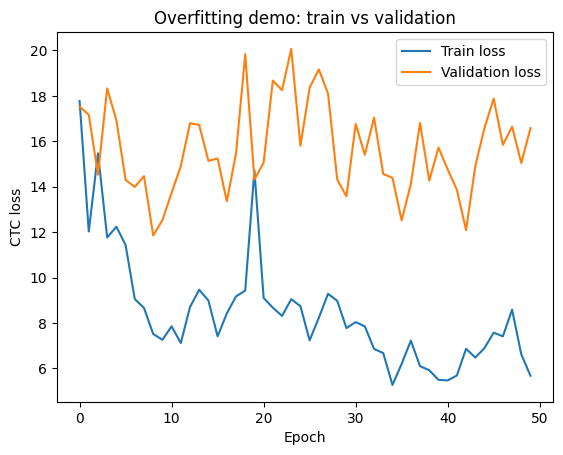

In [59]:
model_tr, train_losses, val_losses = training_wav2vecASR2(
    model, train_ds, val_ds, num_epochs=50, loss_fn=loss_fn, learning_rate=learning_rate
)

plt.figure()
plt.plot(train_losses, label="Train loss")
plt.plot(val_losses, label="Validation loss")
plt.xlabel("Epoch")
plt.ylabel("CTC loss")
plt.title("Overfitting demo: train vs validation")
plt.legend()
plt.show()

## Question

Experiment with validation split and tell me any changes you observe in the graph. Why do they occur?

In [60]:
model = Wav2vecASR(n_labels)
model.wav2vec.apply(freeze_params)
model.output_layer.apply(init_params)

Linear(in_features=768, out_features=29, bias=True)

In [61]:
# Your code
MAX_FILES = 50
asrdataset = ASRdataset(data_speech_dir, data_transc_dir, dico_labels, MAX_FILES=MAX_FILES)

val_ratio = 0.4
n_total = len(asrdataset)
n_val = max(1, int(n_total * val_ratio))
n_train = n_total - n_val

train_ds, val_ds = random_split(asrdataset, [n_train, n_val])

print("Train:", len(train_ds), "Val:", len(val_ds))

Train: 30 Val: 20


Epoch [1/50]  Train: 17.7521  Val: 17.7036
Epoch [2/50]  Train: 14.4537  Val: 14.7313
Epoch [3/50]  Train: 14.5655  Val: 16.9770
Epoch [4/50]  Train: 14.3357  Val: 17.2452
Epoch [5/50]  Train: 13.1611  Val: 14.6013
Epoch [6/50]  Train: 10.0652  Val: 13.9717
Epoch [7/50]  Train: 9.4886  Val: 12.2874
Epoch [8/50]  Train: 14.0513  Val: 13.7611
Epoch [9/50]  Train: 11.0003  Val: 12.6768
Epoch [10/50]  Train: 9.3210  Val: 11.5354
Epoch [11/50]  Train: 9.3472  Val: 15.9062
Epoch [12/50]  Train: 8.9808  Val: 11.8773
Epoch [13/50]  Train: 9.1399  Val: 13.9663
Epoch [14/50]  Train: 9.7106  Val: 12.8750
Epoch [15/50]  Train: 7.5854  Val: 13.0113
Epoch [16/50]  Train: 8.6297  Val: 13.0209
Epoch [17/50]  Train: 10.2419  Val: 13.4175
Epoch [18/50]  Train: 8.5216  Val: 14.4971
Epoch [19/50]  Train: 8.5216  Val: 12.8999
Epoch [20/50]  Train: 8.5196  Val: 12.1482
Epoch [21/50]  Train: 9.9589  Val: 15.1923
Epoch [22/50]  Train: 8.9652  Val: 14.5565
Epoch [23/50]  Train: 8.7891  Val: 14.9651
Epoch [24/5

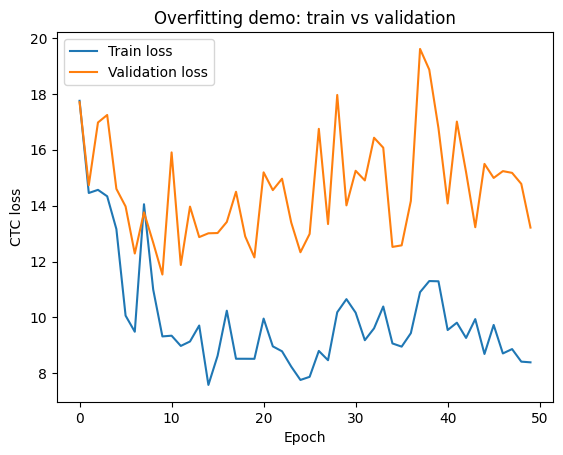

In [62]:
model_tr, train_losses, val_losses = training_wav2vecASR2(
    model, train_ds, val_ds, num_epochs=50, loss_fn=loss_fn, learning_rate=learning_rate
)

plt.figure()
plt.plot(train_losses, label="Train loss")
plt.plot(val_losses, label="Validation loss")
plt.xlabel("Epoch")
plt.ylabel("CTC loss")
plt.title("Overfitting demo: train vs validation")
plt.legend()
plt.show()

# Optimizers

In deep learning, **optimizers** are the algorithms that decide how a model’s parameters are updated during training, and different optimizers behave differently (for example, SGD, Adam, RMSprop). In this course we use **Adam**, which is a popular choice for fine-tuning because it adapts the learning step automatically for each parameter, but it also exposes several **tunable hyperparameters** that strongly affect training behavior. During fine-tuning, these parameters can change how fast the model learns, how stable training is, and how much the model overfits. **Read the official Adam documentation** and identify which parameters can be adjusted (such as those controlling step size, regularization, and gradient smoothing), and to think about how changing them would affect training and validation curves during fine-tuning.

https://www.analyticsvidhya.com/blog/2023/12/adam-optimizer/

## Question

Lits Adam's parameters that can be fine-tuned and what they are responsible for.

Adam can be fine-tuned through a few key parameters: the learning rate (α), which controls how large each update step is; β₁, which determines how much past gradients are remembered (momentum, smoothing updates over time); β₂, which controls how much past squared gradients are remembered (adapting the learning rate based on gradient variance); ε, a small constant added for numerical stability to avoid division by zero; weight decay (in AdamW), which acts as L2 regularization to prevent overfitting by discouraging large weights; and AMSGrad (optional), a variant that improves theoretical convergence by using the maximum past second-moment estimate, sometimes at the cost of slower training.

## Question

Experiment with one of Adam's parameters, describe the outcome and any changes you observe in the graphs. 

In [64]:
model = Wav2vecASR(n_labels)
model.wav2vec.apply(freeze_params)
model.output_layer.apply(init_params)

Linear(in_features=768, out_features=29, bias=True)

In [63]:
# Your code
MAX_FILES = 50
asrdataset = ASRdataset(data_speech_dir, data_transc_dir, dico_labels, MAX_FILES=MAX_FILES)

val_ratio = 0.2
n_total = len(asrdataset)
n_val = max(1, int(n_total * val_ratio))
n_train = n_total - n_val

train_ds, val_ds = random_split(asrdataset, [n_train, n_val])

print("Train:", len(train_ds), "Val:", len(val_ds))

Train: 40 Val: 10


Epoch [1/50]  Train: 4.1136  Val: 3.4241
Epoch [2/50]  Train: 4.0461  Val: 3.5197
Epoch [3/50]  Train: 3.0349  Val: 3.1894
Epoch [4/50]  Train: 2.8963  Val: 3.0590
Epoch [5/50]  Train: 2.5484  Val: 2.9580
Epoch [6/50]  Train: 2.5733  Val: 3.0693
Epoch [7/50]  Train: 3.1533  Val: 3.2662
Epoch [8/50]  Train: 2.3789  Val: 2.9521
Epoch [9/50]  Train: 2.2768  Val: 2.8227
Epoch [10/50]  Train: 2.2619  Val: 3.1373
Epoch [11/50]  Train: 2.1560  Val: 2.9596
Epoch [12/50]  Train: 2.0611  Val: 2.7184
Epoch [13/50]  Train: 2.0929  Val: 2.9286
Epoch [14/50]  Train: 2.0094  Val: 3.2665
Epoch [15/50]  Train: 2.0002  Val: 2.8995
Epoch [16/50]  Train: 1.9092  Val: 3.0505
Epoch [17/50]  Train: 1.9821  Val: 2.7940
Epoch [18/50]  Train: 2.0418  Val: 3.1677
Epoch [19/50]  Train: 1.9361  Val: 2.9526
Epoch [20/50]  Train: 1.8447  Val: 2.7595
Epoch [21/50]  Train: 1.8342  Val: 2.8910
Epoch [22/50]  Train: 1.8535  Val: 2.7774
Epoch [23/50]  Train: 1.8604  Val: 2.8149
Epoch [24/50]  Train: 1.7926  Val: 2.8456
E

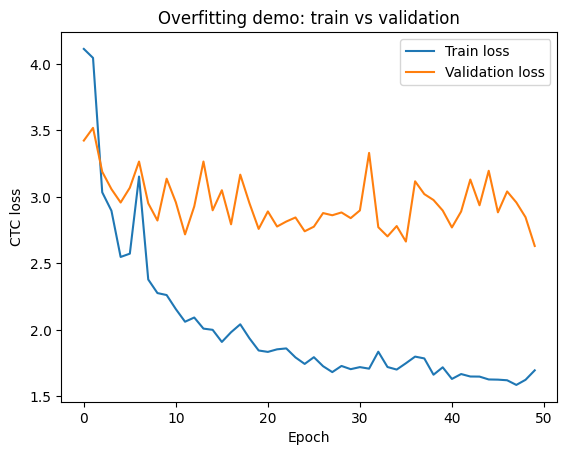

In [65]:
# Chaning learning rate
model_tr, train_losses, val_losses = training_wav2vecASR2(
    model, train_ds, val_ds, num_epochs=50, loss_fn=loss_fn, learning_rate=0.01
)

plt.figure()
plt.plot(train_losses, label="Train loss")
plt.plot(val_losses, label="Validation loss")
plt.xlabel("Epoch")
plt.ylabel("CTC loss")
plt.title("Overfitting demo: train vs validation")
plt.legend()
plt.show()

## Additional Material on TDNN and CNN

TDNN: https://kaleidoescape.github.io/tdnn/

CNN: https://towardsdatascience.com/convolutional-neural-networks-explained-9cc5188c4939/

IN SHORT: 

A CNN (Convolutional Neural Network) is a model that learns by looking at small pieces of data at a time and reusing the same pattern-detector everywhere, like sliding a small window along the data to spot useful patterns. A TDNN (Time-Delay Neural Network) does the same thing, but specifically for data that changes over time, such as speech: it looks at a few time steps before and after the current moment to understand what is happening now. In practice, a TDNN is simply a 1-dimensional CNN applied along the time axis, designed to recognize temporal patterns while being insensitive to small time shifts.

A one-dimensional CNN (1D CNN) is a neural network that looks for patterns along a single line, not across a 2-D surface like an image. Imagine a row of numbers changing over time, such as a speech signal, sound features, or a sentence represented as numbers. A 1D CNN uses a small moving window that slides left to right along this row and checks each small chunk for patterns (for example, a short sound shape or a word pattern). The same detector is reused everywhere, so the network learns to recognize a pattern no matter where it appears in time. This makes 1D CNNs good at handling sequences like audio, where timing may shift slightly but the pattern itself stays the same.

## Question:

Read the materials on CNN AND TDNN and explain the architecture in your own words, be detailed. What are the advantages of TDNN compared to CNN?

## Coding blocks and questions that will be tested next class:

In [66]:
# INSPECTING TENSOR SHAPE
x = torch.randn(300, 80)
print("dims:", x.dim())
print("shape:", x.shape)


dims: 2
shape: torch.Size([300, 80])


In [67]:
# ADDING DIMENSION
x = torch.randn(300, 80)
x = x.unsqueeze(0)
print(x.shape)  # (1, 300, 80)



torch.Size([1, 300, 80])


* What is a tensor, in simple words?
* Give me an example tensor used as input into the linear layer of an asr system and explain the contents.
* Give me three different ways to manipulate tensors and explain what they do.
* What is overfitting, and how does it appear on training vs validation loss curves?
* What is underfitting, and how do its loss curves look?
* Explain how Adam optimizer works in short, What is the role of it in neural network training?
* What parameters does Adam optimizer have, what are they responsible for?
* What is the benefit of the TDNN architecture compared to a conventional CNN? Explain both architectures. (You will need to google for this one or refer to your lecture slides)


A tensor is a way to store numbers in an organized shape. A single number is a tensor (0-D), a list of numbers is a tensor (1-D), a table is a tensor (2-D), and you can continue to higher dimensions. It’s basically a generalization of scalars, vectors, and matrices that lets us represent data with many indices, which is very useful in physics and machine learning.

In an ASR system, a linear layer often receives a 2-D or 3-D tensor representing acoustic features over time. For example, imagine a tensor of shape (batch_size, time_steps, feature_dim) = (16, 200, 80). This means we process 16 audio clips at once; each clip is divided into 200 time frames; and for every frame we have an 80-dimensional feature vector (such as log-Mel filterbank values) describing the sound spectrum at that moment. The linear layer uses these numbers to transform the acoustic information into a new representation, often closer to phonemes or characters.

Reshaping (view() or reshape()) changes the organization of the data without changing the actual values. For example, you can convert a long vector into a matrix so it matches the input shape expected by a neural network layer.

Indexing / slicing (tensor[i], tensor[:, 0], etc.) selects part of the tensor. You might extract one sample from a batch or choose a specific time frame from speech features.

Concatenation (torch.cat()) joins multiple tensors along a specified dimension. For instance, you can combine two feature vectors into a longer vector that contains information from both.

Overfitting happens when a model learns the training data too well, including noise or accidental patterns, and therefore does not generalize to new data. On the loss curves, you usually see the training loss keep decreasing, while the validation loss stops improving and starts increasing after some point. This gap between them is a sign that the model is memorizing the training set instead of learning general rules.

Underfitting happens when a model is too simple or not trained enough to learn the important patterns in the data. As a result, it performs poorly on both the training set and new data. On the loss curves, you usually see both training and validation loss staying high and often decreasing only a little, with no big gap between them. This shows the model has not learned the task well.

The Adam optimizer is a method for updating a neural network’s weights to reduce loss. It combines momentum (keeping track of past gradients to smooth updates) and adaptive learning rates (scaling updates for each weight based on past gradients). Its role is to help the network learn efficiently and converge faster by adjusting how much each weight changes at each step, making training more stable and often faster than simple gradient descent.

The Adam optimizer has a few main parameters:

lr (learning rate): Controls the size of each weight update; higher values make faster learning but can overshoot minima.

betas (beta1, beta2): beta1 controls the momentum (how much past gradients affect the current update), and beta2 controls the running average of squared gradients (used for adaptive scaling).

eps (epsilon): A small number to prevent division by zero in the update step.

weight_decay (optional): Adds regularization to prevent overfitting by slightly shrinking weights during training.

These parameters together balance speed, stability, and generalization during training.

A Time Delay Neural Network (TDNN) is a type of architecture that explicitly models temporal context by learning from a window of past (and sometimes future) frames at each layer, effectively acting like a 1‑D convolution across time where each layer sees a broader time span than the one before. In speech recognition this means TDNN layers can capture patterns that unfold over time (like phonetic context) without relying on external memory or recurrence, and they are shift‑invariant along the time axis so the same patterns can be recognized anywhere in the input sequence.

A conventional CNN, by comparison, typically refers to a convolutional neural network that processes locality in one or more dimensions (often frequency and time for spectrograms) using fixed‑size filters that learn spatial patterns. In vision this means detecting local image features; in audio it means extracting short, local structures from a spectrogram. The convolution filters slide over the input and share weights, capturing local structure but without an explicit design for modeling broader temporal context unless many layers or dilations are added.

The benefit of TDNN over a standard CNN in ASR is that TDNN’s temporal convolutions and context windows are specifically designed to capture longer temporal dependencies in speech with fewer parameters and more efficient modeling of sequential context, which often yields better acoustic modeling for speech patterns that unfold over time. CNNs, while powerful for local feature extraction, may require deeper stacks or additional mechanisms to capture the same temporal context that a TDNN inherently models.